In [1]:
import os
import cv2
import dlib
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(r"C:\Users\ishan\Downloads\shape_predictor_68_face_landmarks.dat")

In [2]:
landmark_features = []
labels = []
data_dir = r"C:\Users\ishan\OneDrive\Desktop\face recog\newf"

In [4]:
data = np.load('landmarks_and_labels.npz')
landmark_features = data['landmarks']
labels = data['labels']
print("Landmarks shape:", landmark_features.shape)
print("Labels shape:", labels.shape)

Landmarks shape: (4518, 136)
Labels shape: (4518,)


In [ ]:

# for person in os.listdir(data_dir):
#     person_dir = os.path.join(data_dir, person)
#     if not os.path.isdir(person_dir):
#         continue
#     for file in tqdm(os.listdir(person_dir), desc=f"Processing {person}"):
#         img_path = os.path.join(person_dir, file)
#         img = cv2.imread(img_path)
#         if img is None:
#             continue
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         faces = detector(gray)
#         if len(faces) == 0:
#             continue  # No face detected
#         # Use the first detected face
#         shape = predictor(gray, faces[0])
#         # Extract (x, y) coordinates for 68 landmarks
#         landmarks = np.array([[pt.x, pt.y] for pt in shape.parts()])  # (68, 2)
#         landmarks_flat = landmarks.flatten()  # (136,)
#         landmark_features.append(landmarks_flat)
#         labels.append(person)

# print(f"Extracted {len(landmark_features)} landmark feature vectors.")

# # Convert to numpy arrays for ML use
# landmark_features = np.array(landmark_features)
# labels = np.array(labels)
# print("Landmark features shape:", landmark_features.shape)  # (num_images, 136

Processing Zoran_Djindjic: 100%|██████████| 5/5 [00:00<00:00, 67.72it/s]

Extracted 4518 landmark feature vectors.
Landmark features shape: (4518, 136)


In [7]:
np.savez('landmarks_and_labels.npz', landmarks=landmark_features, labels=labels)

In [8]:
def euclidean_distance(pt1, pt2):
    return np.linalg.norm(np.array(pt1) - np.array(pt2))

def angle_between(p1, p2, p3):
    a = np.array(p1) - np.array(p2)
    b = np.array(p3) - np.array(p2)
    cos_angle = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
    return np.degrees(angle)

def compute_geometric_features(landmarks):
    # Example indices for left eye, right eye, nose tip, chin, mouth corners, jaw, eyebrows
    features = []
    features.append(euclidean_distance(landmarks[36], landmarks[45]))  # Eye distance
    features.append(euclidean_distance(landmarks[30], landmarks[8]))   # Nose tip to chin
    features.append(euclidean_distance(landmarks[48], landmarks[54]))  # Mouth width
    features.append(euclidean_distance(landmarks[3], landmarks[13]))   # Jaw width
    features.append(euclidean_distance(landmarks[21], landmarks[22]))  # Between eyebrows
    mouth_width = features[2]
    jaw_width = features[3]
    features.append(mouth_width / jaw_width if jaw_width != 0 else 0)  # Mouth to jaw ratio
    features.append(angle_between(landmarks[36], landmarks[27], landmarks[45]))  # Eye-brow-eye angle
    features.append(angle_between(landmarks[27], landmarks[30], landmarks[8]))   # Nose bridge angle
    return np.array(features)


In [9]:
# Reshape to (num_images, 68, 2)
landmark_features_reshaped = landmark_features.reshape(-1, 68, 2)
geometric_features = np.array([compute_geometric_features(lm) for lm in landmark_features_reshaped])


In [10]:
pairs_features = []
pairs_labels = []

num_images = len(geometric_features)
# Example: pair consecutive images for positives, skip for negatives
for i in range(0, num_images - 2, 2):
    # Positive pair
    pair_pos = np.abs(geometric_features[i] - geometric_features[i+1])
    pairs_features.append(pair_pos)
    pairs_labels.append(1)
    # Negative pair
    pair_neg = np.abs(geometric_features[i] - geometric_features[i+2])
    pairs_features.append(pair_neg)
    pairs_labels.append(0)

pairs_features = np.array(pairs_features)
pairs_labels = np.array(pairs_labels)


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [13]:

class MLP(nn.Module):
    def __init__(self, input_dim=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [14]:

model = MLP(input_dim=1024).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_x.size(0)

        preds = (outputs > 0.5).float()
        correct_train += (preds == batch_y).sum().item()
        total_train += batch_y.size(0)

    epoch_loss = running_loss / total_train
    train_acc = correct_train / total_train
    print(f"Epoch {epoch+1}/{epochs} — Loss: {epoch_loss:.4f}, Accuracy: {train_acc:.4f}")

NameError: name 'train_loader' is not defined

C:\Users\ishan\AppData\Local\Temp\ipykernel_14288\67596303.py:5: RuntimeWarning: divide by zero encountered in divide
  scaled = translated / eye_distance
C:\Users\ishan\AppData\Local\Temp\ipykernel_14288\67596303.py:5: RuntimeWarning: invalid value encountered in divide
  scaled = translated / eye_distance


In [7]:
import numpy as np
from collections import Counter

# Count number of samples per class
label_counts = Counter(labels)

# Keep only labels that have at least 2 samples
valid_labels = {label for label, count in label_counts.items() if count >= 2}

# Apply filtering
filtered_landmarks = []
filtered_labels = []

for i, label in enumerate(labels):
    if label in valid_labels:
        filtered_landmarks.append(landmark_features[i])
        filtered_labels.append(label)

# Convert to arrays
landmark_features = np.array(filtered_landmarks)
labels = np.array(filtered_labels)

print("Filtered shape:", landmark_features.shape, labels.shape)


Filtered shape: (4413, 136) (4413,)


In [8]:
def normalize_landmarks(landmarks):
    nose = landmarks[30]
    translated = landmarks - nose
    eye_distance = np.linalg.norm(landmarks[36] - landmarks[45])
    scaled = translated / eye_distance
    return scaled.flatten()

# Apply normalization to all samples
X = np.array([normalize_landmarks(lm) for lm in landmark_features])

C:\Users\ishan\AppData\Local\Temp\ipykernel_14288\67596303.py:5: RuntimeWarning: divide by zero encountered in divide
  scaled = translated / eye_distance
C:\Users\ishan\AppData\Local\Temp\ipykernel_14288\67596303.py:5: RuntimeWarning: invalid value encountered in divide
  scaled = translated / eye_distance


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels (if they're strings or IDs)
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


ValueError: The test_size = 883 should be greater or equal to the number of classes = 1394

In [10]:
from collections import Counter
import numpy as np

# Load your data
data = np.load('landmarks_and_labels.npz')
landmark_features = data['landmarks']
labels = data['labels']

# Count samples per class
label_counts = Counter(labels)

# Keep only labels with ≥ 2 samples
valid_labels = {label for label, count in label_counts.items() if count >= 2}

# Filter the data
filtered_landmarks = []
filtered_labels = []

for i in range(len(labels)):
    if labels[i] in valid_labels:
        filtered_landmarks.append(landmark_features[i])
        filtered_labels.append(labels[i])

filtered_landmarks = np.array(filtered_landmarks)
filtered_labels = np.array(filtered_labels)

print("After filtering:", filtered_landmarks.shape, filtered_labels.shape)


After filtering: (4413, 136) (4413,)


In [11]:
def normalize_landmarks(landmarks):
    nose = landmarks[30]
    translated = landmarks - nose
    eye_distance = np.linalg.norm(landmarks[36] - landmarks[45])
    scaled = translated / (eye_distance + 1e-6)
    return scaled.flatten()  # output shape: (136,)

X = np.array([normalize_landmarks(lm) for lm in filtered_landmarks])

# === Encode labels ===
encoder = LabelEncoder()
y = encoder.fit_transform(filtered_labels)

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === One-hot encode labels ===
num_classes = len(np.unique(y))
y_train_oh = to_categorical(y_train, num_classes)
y_test_oh = to_categorical(y_test, num_classes)


ValueError: The test_size = 883 should be greater or equal to the number of classes = 1394

In [13]:
import numpy as np
from collections import defaultdict

# Load the data
data = np.load('landmarks_and_labels.npz')
landmarks = data['landmarks']  # shape: (N, 136)
labels = data['labels']        # shape: (N,)

# Group landmarks under their corresponding labels
grouped_by_label = defaultdict(list)

for feature, label in zip(landmarks, labels):
    grouped_by_label[label].append(feature)

# Optional: print some info
for label, features in grouped_by_label.items():
    print(f"Label: {label}, Number of images: {len(features)}")


Label: Aaron_Peirsol, Number of images: 4
Label: Aaron_Sorkin, Number of images: 2
Label: Abdel_Nasser_Assidi, Number of images: 2
Label: Abdoulaye_Wade, Number of images: 2
Label: Abdullah, Number of images: 4
Label: Abdullah_al-Attiyah, Number of images: 2
Label: Abdullatif_Sener, Number of images: 3
Label: Abel_Pacheco, Number of images: 3
Label: Abid_Hamid_Mahmud_Al-Tikriti, Number of images: 2
Label: Adam_Sandler, Number of images: 4
Label: Adam_Scott, Number of images: 1
Label: Adel_Al-Jubeir, Number of images: 2
Label: Adolfo_Aguilar_Zinser, Number of images: 3
Label: Adolfo_Rodriguez_Saa, Number of images: 1
Label: Adrian_McPherson, Number of images: 1
Label: Adrian_Nastase, Number of images: 2
Label: Ahmad_Masood, Number of images: 1
Label: Ahmed_Chalabi, Number of images: 5
Label: Ahmet_Necdet_Sezer, Number of images: 2
Label: Aicha_El_Ouafi, Number of images: 3
Label: Aitor_Gonzalez, Number of images: 2
Label: Ai_Sugiyama, Number of images: 5
Label: Akbar_Hashemi_Rafsanjani,

In [7]:
import dlib
import cv2
import numpy as np
import os

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("C:/Users/ishan/Downloads/shape_predictor_68_face_landmarks.dat")

In [10]:
def resize_for_detection(image, max_dim=800):
    h, w = image.shape[:2]
    scale = max_dim / max(h, w)
    if scale != 1:
        return cv2.resize(image, (int(w * scale), int(h * scale)))
    return image

In [11]:
def get_landmarks(image):
    image = resize_for_detection(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    faces = detector(gray)
    if len(faces) == 0:
        return None
    shape = predictor(gray, faces[0])
    return [(p.x, p.y) for p in shape.parts()]

def extract_metrics(landmarks):
    def euclidean(p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))
    
    metrics = []
    metrics.append(euclidean(landmarks[36], landmarks[39]))  # left eye width
    metrics.append(euclidean(landmarks[42], landmarks[45]))  # right eye width
    metrics.append(euclidean(landmarks[30], landmarks[8]))   # nose to chin
    metrics.append(euclidean(landmarks[48], landmarks[54]))  # mouth width
    metrics.append(euclidean(landmarks[21], landmarks[22]))  # eyebrows
    metrics.append(euclidean(landmarks[27], landmarks[8]))   # nose bridge

    # Normalize
    normalization = euclidean(landmarks[36], landmarks[45])
    metrics = [m / normalization for m in metrics]
    
    return np.array(metrics)

def build_metrics_from_folders(base_dir):
    metric_dict = {}
    label_dict = {}

    for person in os.listdir(base_dir):
        person_path = os.path.join(base_dir, person)
        if not os.path.isdir(person_path):
            continue

        for img_file in os.listdir(person_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(person_path, img_file)
                img = cv2.imread(img_path)
                landmarks = get_landmarks(img)

                if landmarks:
                    metrics = extract_metrics(landmarks)
                    metric_dict[img_path] = metrics
                    label_dict[img_path] = person
                else:
                    print(f"No face found in {img_file}, skipping.")

    return metric_dict, label_dict


In [12]:
base_folder = r"C:\Users\ishan\OneDrive\Desktop\face recog\newf"
metric_dict, label_dict = build_metrics_from_folders(base_folder)

No face found in Abdel_Nasser_Assidi_0001_2.jpg, skipping.
No face found in Abdel_Nasser_Assidi_0002_2.jpg, skipping.
No face found in Abdoulaye_Wade_0003_1.jpg, skipping.
No face found in Abdullah_al-Attiyah_0001_1.jpg, skipping.
No face found in Abdullah_al-Attiyah_0002_1.jpg, skipping.
No face found in Adam_Scott_0001_1.jpg, skipping.
No face found in Adolfo_Aguilar_Zinser_0002_2.jpg, skipping.
No face found in Adolfo_Rodriguez_Saa_0001_1.jpg, skipping.
No face found in Adrian_McPherson_0001_1.jpg, skipping.
No face found in Adrian_Nastase_0001_1.jpg, skipping.
No face found in Ahmed_Chalabi_0002_1.jpg, skipping.
No face found in Ahmed_Chalabi_0004_2.jpg, skipping.
No face found in Akbar_Hashemi_Rafsanjani_0002_1.jpg, skipping.
No face found in Akbar_Hashemi_Rafsanjani_0003_1.jpg, skipping.
No face found in Akhmed_Zakayev_0002_1.jpg, skipping.
No face found in Alan_Greenspan_0001_1.jpg, skipping.
No face found in Alan_Greenspan_0005_1.jpg, skipping.
No face found in Alastair_Campbel

KeyboardInterrupt: 

In [ ]:
#USAGE: python facial_68_Landmark.py

import dlib,cv2
import numpy as np
from facePoints import facePoints

def writeFaceLandmarksToLocalFile(faceLandmarks, fileName):
  with open(fileName, 'w') as f:
    for p in faceLandmarks.parts():
      f.write("%s %s\n" %(int(p.x),int(p.y)))

  f.close()

# location of the model (path of the model).
Model_PATH = "shape_predictor_68_face_landmarks.dat"


# now from the dlib we are extracting the method get_frontal_face_detector()
# and assign that object result to frontalFaceDetector to detect face from the image with 
# the help of the 68_face_landmarks.dat model
frontalFaceDetector = dlib.get_frontal_face_detector()


# Now the dlip shape_predictor class will take model and with the help of that, it will show 
faceLandmarkDetector = dlib.shape_predictor(Model_PATH)

# We now reading image on which we applied our face detector
image = "test.jpg"

# Now we are reading image using openCV
img= cv2.imread(image)
imageRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# landmarks of the face image  will be stored in output/image_k.txt
faceLandmarksOuput= "output/image"

# Now this line will try to detect all faces in an image either 1 or 2 or more faces
allFaces = frontalFaceDetector(imageRGB, 0)


print("List of all faces detected: ",len(allFaces))

# List to store landmarks of all detected faces
allFacesLandmark = []

# Below loop we will use to detect all faces one by one and apply landmarks on them

for k in range(0, len(allFaces)):
  # dlib rectangle class will detecting face so that landmark can apply inside of that area
  faceRectangleDlib = dlib.rectangle(int(allFaces[k].left()),int(allFaces[k].top()),
      int(allFaces[k].right()),int(allFaces[k].bottom()))

  # Now we are running loop on every detected face and putting landmark on that with the help of faceLandmarkDetector
  detectedLandmarks = faceLandmarkDetector(imageRGB, faceRectangleDlib)
  
  # count number of landmarks we actually detected on image
  if k==0:
    print("Total number of face landmarks detected ",len(detectedLandmarks.parts()))

  # Svaing the landmark one by one to the output folder
  allFacesLandmark.append(detectedLandmarks)

  # Now finally we drawing landmarks on face
  facePoints(img, detectedLandmarks)

  fileName = faceLandmarksOuput +"_"+ str(k)+ ".txt"
  print("Lanmdark is save into ", fileName)

  # Write landmarks to disk
  writeFaceLandmarksToLocalFile(detectedLandmarks, fileName)

#Name of the output file
outputNameofImage = "output/image.jpg"
print("Saving output image to", outputNameofImage)
cv2.imwrite(outputNameofImage, img)

cv2.imshow("Face landmark result", img)

# Pause screen to wait key from user to see result
cv2.waitKey(0)
cv2.destroyAllWindows()


In [13]:
import dlib, cv2
import numpy as np
from facePoints import facePoints

ModuleNotFoundError: No module named 'facePoints'

In [2]:
import cv2
import mediapipe as mp
image = cv2.imread(r"C:\Users\ishan\Downloads\IMG_2007.JPG")

In [5]:
# Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = face_mesh.process(rgb_image)
height, width, _ = image.shape

for facial_landmarks in result.multi_face_landmarks:
    for i in range(0, 468):
        pt1 = facial_landmarks.landmark[i]
        x = int(pt1.x * width)
        y = int(pt1.y * height)

        cv2.circle(image, (x, y), 5, (100, 100, 0), -1)

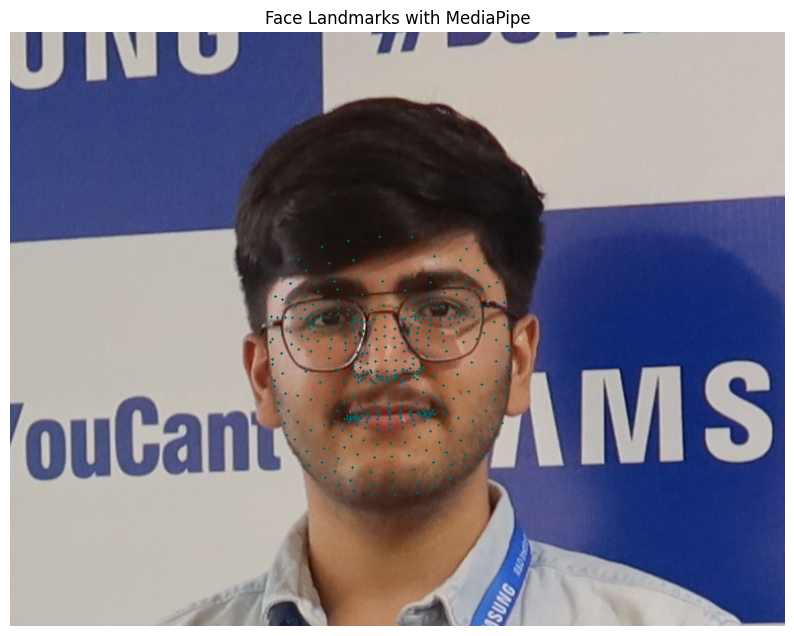

In [3]:
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp

# Load your image # Replace with your image path
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# Process the image
result = face_mesh.process(rgb_image)
height, width, _ = image.shape

# Draw landmarks on a copy of the image
annotated_image = image.copy()
if result.multi_face_landmarks:
    for facial_landmarks in result.multi_face_landmarks:
        for i in range(0, 468):
            pt1 = facial_landmarks.landmark[i]
            x = int(pt1.x * width)
            y = int(pt1.y * height)
            cv2.circle(annotated_image, (x, y), 1, (100, 100, 0), -1)

# Convert BGR to RGB for matplotlib display
annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

# Plot with matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image_rgb)
plt.axis('off')
plt.title("Face Landmarks with MediaPipe")
plt.show()
